In [6]:
import os
os.chdir('/workspace/NN')

import torch
from RobustVideoMatting.model import MattingNetwork

model = MattingNetwork('mobilenetv3').eval().cuda()  # or "resnet50"
model.load_state_dict(torch.load('/workspace/NN/weights/rvm_mobilenetv3.pth'))


/tmp/ipykernel_5062/2008495669.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/workspace/NN/weights/rvm_mobilenetv3.pth'))


<All keys matched successfully>

In [14]:
# from RobustVideoMatting.inference import

In [15]:
import os

os.chdir('/workspace/NN')

import sys
import argparse
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from MODNet.src.models.modnet import MODNet



/tmp/ipykernel_5019/1137001007.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(args.ckpt_path)


Process image: /workspace/NN/data/sirius_data/0.jpg
Process image: /workspace/NN/data/sirius_data/1.jpg
Process image: /workspace/NN/data/sirius_data/2.jpg
Process image: /workspace/NN/data/sirius_data/3.jpg
Process image: /workspace/NN/data/sirius_data/4.jpg
Process image: /workspace/NN/data/sirius_data/5.jpg
Process image: /workspace/NN/data/sirius_data/6.jpg
Process image: /workspace/NN/data/sirius_data/7.jpg
Process image: /workspace/NN/data/sirius_data/8.jpg
Process image: /workspace/NN/data/sirius_data/9.jpg
Process image: /workspace/NN/data/sirius_data/10.jpg
Process image: /workspace/NN/data/sirius_data/11.jpg
Process image: /workspace/NN/data/sirius_data/12.jpg
Process image: /workspace/NN/data/sirius_data/13.jpg
Process image: /workspace/NN/data/sirius_data/14.jpg
Process image: /workspace/NN/data/sirius_data/15.jpg


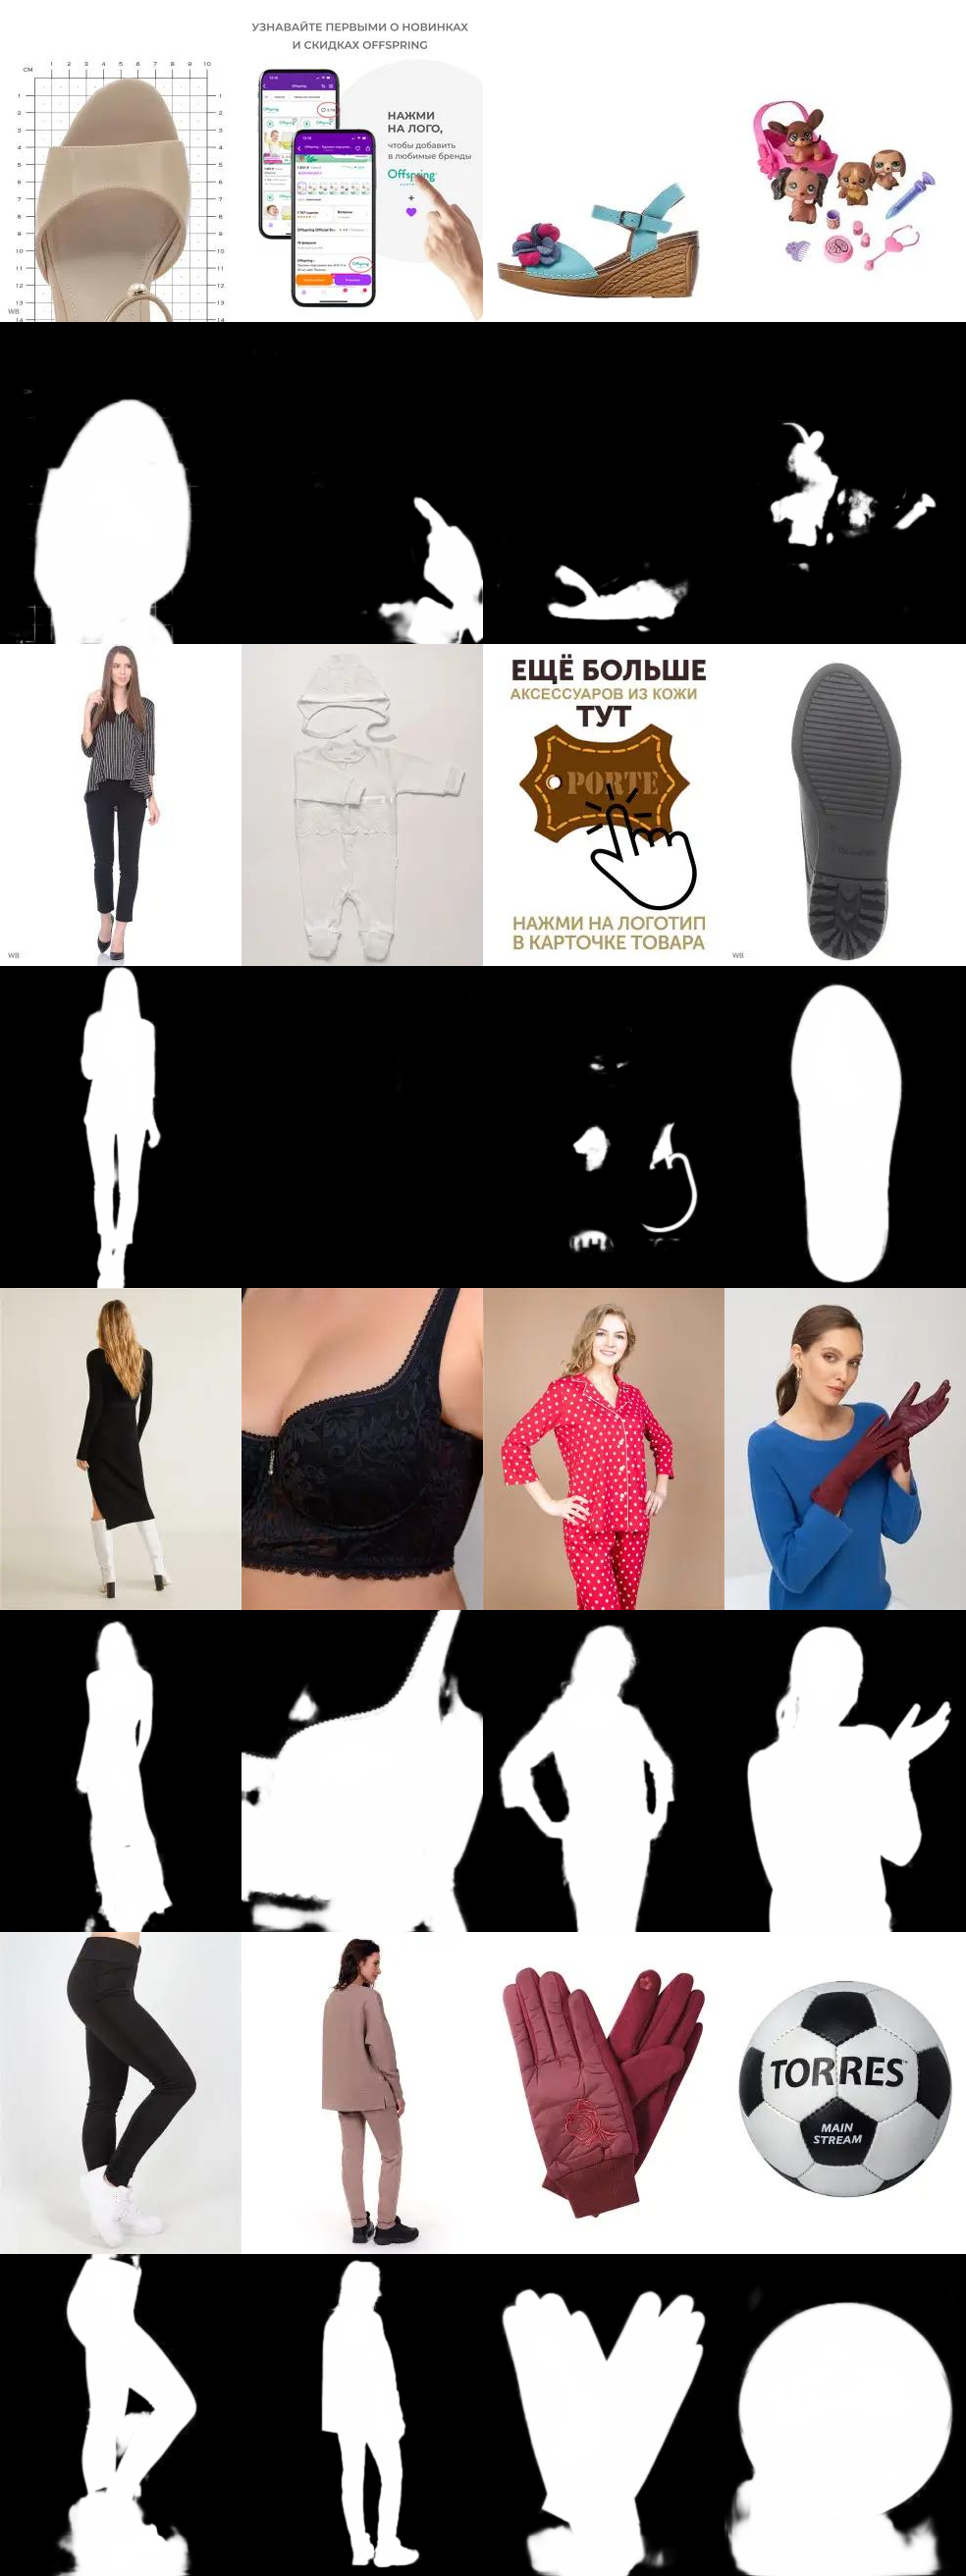

In [30]:

if True:
    # define cmd arguments
    # parser = argparse.ArgumentParser()
    # parser.add_argument('--input-path', type=str, help='path of input images')
    # parser.add_argument('--output-path', type=str, help='path of output images')
    # parser.add_argument('--ckpt-path', type=str, help='path of pre-trained MODNet')
    # args = parser.parse_args()

    # check input arguments
    # if not os.path.exists(args.input_path):
    #     print('Cannot find input path: {0}'.format(args.input_path))
    #     exit()
    # if not os.path.exists(args.output_path):
    #     print('Cannot find output path: {0}'.format(args.output_path))
    #     exit()
    # if not os.path.exists(args.ckpt_path):
    #     print('Cannot find ckpt path: {0}'.format(args.ckpt_path))
    #     exit()

    args = type("Emp", (object,), dict())
    args.input_path = input_folder
    args.output_path = output_folder
    args.ckpt_path = pretrained_ckpt

    # define hyper-parameters
    ref_size = 512

    # define image to tensor transform
    im_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

    # create MODNet and load the pre-trained ckpt
    modnet = MODNet(backbone_pretrained=False)
    modnet = nn.DataParallel(modnet)

    if torch.cuda.is_available():
        modnet = modnet.cuda()
        weights = torch.load(args.ckpt_path)
    else:
        weights = torch.load(args.ckpt_path, map_location=torch.device('cpu'))
    modnet.load_state_dict(weights)
    modnet.eval()


    ROOT_PATH = '/workspace/NN'
    DATA_PATCH = os.path.join(ROOT_PATH, 'data')
    # inference images
    im_names =  [ os.path.join(DATA_PATCH, 'sirius_data', f'{i}.jpg') for i in range(16)]
    new_images = []
    for im_name in im_names:
        print('Process image: {0}'.format(im_name))

        # read image
        im = Image.open(os.path.join(args.input_path, im_name))
        new_images.append(im)

        # unify image channels to 3
        im = np.asarray(im)
        if len(im.shape) == 2:
            im = im[:, :, None]
        if im.shape[2] == 1:
            im = np.repeat(im, 3, axis=2)
        elif im.shape[2] == 4:
            im = im[:, :, 0:3]

        # convert image to PyTorch tensor
        im = Image.fromarray(im)
        im = im_transform(im)
        # add mini-batch dim
        im = im[None, :, :, :]

        # resize image for input
        im_b, im_c, im_h, im_w = im.shape
        if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
            if im_w >= im_h:
                im_rh = ref_size
                im_rw = int(im_w / im_h * ref_size)
            elif im_w < im_h:
                im_rw = ref_size
                im_rh = int(im_h / im_w * ref_size)
        else:
            im_rh = im_h
            im_rw = im_w

        im_rw = im_rw - im_rw % 32
        im_rh = im_rh - im_rh % 32
        im = F.interpolate(im, size=(im_rh, im_rw), mode='area')

        # inference
        _, _, matte = modnet(im.cuda() if torch.cuda.is_available() else im, True)

        # resize and save matte
        matte = F.interpolate(matte, size=(im_h, im_w), mode='area')
        matte = matte[0][0].data.cpu().numpy()

        matte_name = im_name.split('.')[0] + '.png'
        new_images.append(Image.fromarray(((matte * 255).astype('uint8')), mode='L'))
        new_images[-1].save(os.path.join(args.output_path, matte_name))



#opens an image:
# im = Image.open("1_tree.jpg")
#creates a new empty image, RGB mode, and size 400 by 400.
new_im = Image.new('RGBA', (246 * 4, 328* 8))
images_without_background = new_images
#Here I resize my opened image, so it is no bigger than 100,100
#
#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(0, 4,1):
    for j in range(0, 8,1):
        #I change brightness of the images, just to emphasise they are unique copies.
        # im=Image.eval(im,lambda x: x+(i+j)/30)
        #paste the image at location i,j:
        im = images_without_background[i * 8 + j]
        im.thumbnail((246,328))
        new_im.paste(im, (i*246,j * 328))

new_im.show()

